In [2]:
import ROOT
import pandas as pd
import os
import glob
import subprocess
import shutil
import time
%run binner.ipynb
%run fitter.ipynb
%run systematics.ipynb

Welcome to JupyROOT 6.22/06


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-07ifskzm because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Purpose
---
This analysis script is designed to be the main control center for streamlining the many key components of the dihadron analysis. These include...
1. Binning of event kinematics
2. Fitting the binned TTrees with sideband and sWeights
3. Plotting event variables and particle kinematics for each bin
    a. Reconstructed
    b. sWeighted Reconstructed
    c. Monte Carlo
4. Evaluating systematic errors for each bin and for the whole analysis
    a. Baryon CRF contamination
    b. False identification of the final state
    c. Bin migration in phi_h and phi_R
5. Plotting the resulting asymmetries for each bin

# Output Directory
---
Location to place all results for this analysis. Will be in the ./dihadron/results/ directory. By default, the date and time are used to identify the output directory. The user is prompted below if a prefix should be used

In [9]:
folder = os.getcwd()+"/results/"
t = time.strftime("%Y_%B_%d_%H:%M")
prefix=input("Please input a prefix (if desired) for the output folder name: {}<PREFIX>_{}".format(folder,t))
if(prefix==""):
    folder=folder+t
else:
    folder=folder+prefix+"_"+t
if(os.path.exists(folder)):
    shutil.rmtree(folder); print("Overwriting results folder",folder)
os.mkdir(folder)
print("Created results folder",folder)

Please input a prefix (if desired) for the output folder name: /w/hallb-scshelf2102/clas12/users/gmat/CLAS12Analysis/macros/analysis/rg-a/dihadron/results/<PREFIX>_2022_October_25_10:01 


Created results folder /w/hallb-scshelf2102/clas12/users/gmat/CLAS12Analysis/macros/analysis/rg-a/dihadron/results/2022_October_25_10:01


# Data Location
---
Initializing the folders for the Data and Monte Carlo samplesFor both the reconstructed data tree and monte carlo tree, inquire the user if they would like to reset the binning
    This step is ignored if the "merged_run_binned.root" file/files were not found 

In [10]:
datadir="/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/nSidis/testsmall/"
mcdir="/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/MC/testsmall/"

"""

    Insist that there exists a 'merged_run.root' within the two directories
    This file is generated by mergeTrees.C. See ./makeJobs.sh in the slurm/ directory for details
    
"""

assert(os.path.exists(datadir+"merged_run.root"))
assert(os.path.exists(mcdir+"merged_run.root"))

"""

    Alert the user if there is a pre-existing binned root file
    
"""

datahasbin=False
mchasbin=False
if(os.path.exists(datadir+"merged_run_binned.root")):
    print("NOTE: Binned Root File exists in datadir/"); datahasbin=True
if(os.path.exists(mcdir+"merged_run_binned.root")):
    print("NOTE: Binned Root File exists in mcdir/"); mchasbin=True

NOTE: Binned Root File exists in datadir/
NOTE: Binned Root File exists in mcdir/


# Kinematic Binning (SLURM)
---
Starting from the combined "merged_run.root" script, the user can call upon the "./genBins.sh" script to send a slurm job for each desired kinematic bin. The bins are determined by a binGrid created ahead of time in the "binGrids/" folder. The slurm job will read in the "merged_run.root" script for each bin, and assemble a TTree identical to the "tree_postprocess" in "merged_run.root", except sliced within the user-desired binning scheme. Since multiple slurm jobs are sent at the same time, this step is completed in parallel, saving time. 

In [13]:
"""


    For both the reconstructed data tree and monte carlo tree, inquire the user if they would like to reset the binning
    This step is ignored if the "merged_run_binned.root" file/files were not found 

"""

dobindata=True
dobinmc=True

for d,s,b in zip([datadir,mcdir],["Data","Monte Carlo"],[dobindata,dobinmc]):
    if(not b):
        continue
    else:
        txt = input(s+" directory already has a binned root file. Overwrite? (Y/N)")
        if(txt=="N" or txt=="n"):
            if("Data" in s):
                dobindata=False
            else:
                dobinmc=False
        elif(txt!="Y" and txt!="y"):
            print("ERROR: Must respond (Y/N)")
            assert(False)
        else:
            print("Overwriting "+s+" binning")

"""


    Prompt the user for which binGrid to use for the analysis
    

"""
bg=""
if(dobindata or dobinmc):
    print("The following binGrids are available. Which would you like to use?")
    binGrids=glob.glob("./binGrids/*.dat")
    print(binGrids)
    txt = input()
    try:
        idxfile = binGrids.index(txt)
    except:
        print("ERROR: Unrecognized binGrid",txt)
    bg=binGrids[idxfile]
    print("binGrid ",bg," accepted...using for both data and monte carlo")
    # Copy the binGrid into the results directory
    shutil.copy("binGrids/{}".format(bg),folder)

"""


    Send the binning jobs to ifarm
    

"""

if(dobindata):
    print("-"*25,"\n","Queuing binning script for reconstructed data. Press any key to continue")
    input()
    print("-"*25)
    rungroup,train,name=datadir.split("/")[-4:-1]
    os.system("bash ./genBins.sh "+rungroup+" "+train+" "+name+" "+bg)
    
if(dobinmc):
    print("-"*25,"\n","Queuing binning script for monte carlo. Press any key to continue")
    input()
    print("-"*25)
    rungroup,train,name=mcdir.split("/")[-4:-1]
    os.system("bash ./genBins.sh "+rungroup+" "+train+" "+name+" "+bg)

Data directory already has a binned root file. Overwrite? (Y/N) N
Monte Carlo directory already has a binned root file. Overwrite? (Y/N) N


# Itemizing the Bins
---
By reading in the "merged_run_binned.root" file, we can now create an itemized list of all the bins our analysis program is juggling

In [20]:
binnedDataFile=datadir+"merged_run_binned.root"
binnedMCFile=mcdir+"merged_run_binned.root"

assert(os.path.exists(binnedDataFile) and os.path.exists(binnedMCFile))
print("merged_run_binned.root files exist for both data and MC")

datatfile = ROOT.TFile(binnedDataFile,"READ")
mctfile = ROOT.TFile(binnedDataFile,"READ")

binsData=[l.GetName() for l in datatfile.GetListOfKeys()]
binsMC=[l.GetName() for l in mctfile.GetListOfKeys()]

assert(binsData==binsMC)
print("Bins in the Data TTree and MC TTree match | Found {} total".format(len(binsData)))
bins=binsData
print("-"*125,"\nFirst few bins -->",bins[:5])

merged_run_binned.root files exist for both data and MC
Bins in the Data TTree and MC TTree match | Found 25 total
----------------------------------------------------------------------------------------------------------------------------- 
First few bins --> ['bin1d_x_0.0_0.1', 'bin1d_x_0.1_0.13', 'bin1d_x_0.13_0.16', 'bin1d_x_0.16_0.19', 'bin1d_x_0.19_0.235']


# Fitting (SLURM)
---
After the binning has been completed, it is then time to move onto fitting scripts. For each kinematic bin processed in the previous step, a smaller TTree, subset to the large one in "merged_run.root", is named and placed into "merged_run_binned.root". **AFTER CHECKING THAT ALL BINNING SLURM JOBS ARE COMPLETED** we can then move onto fitting. The fitting simply extracts the azimuthal modulation parameters A_LU using, at this stage, two methods: sPlots and sidebands.

In [39]:
input("Fitting Data and Monte Carlo Bins. Press any key to continue");
for b in bins:

    # Data
    rungroup,train,name=datadir.split("/")[-4:-1]
    subprocess.run(["./genFits.sh",rungroup,train,name,b], stdout=subprocess.DEVNULL)
    
    # MC
    rungroup,train,name=mcdir.split("/")[-4:-1]
    subprocess.run(["./genFits.sh",rungroup,train,name,b], stdout=subprocess.DEVNULL)
    
print("Done")

Fitting Data and Monte Carlo Bins. Press any key to continue 


Done


# Saving Fitting Output to Results Dir
---
**After all the fitting algorithms have been completed** this quick program will copy the proper directories over to the results dir for the analysis

For the pi0 analysis, any sPlots or Sideband data saved will be thus transfered over into one, easy to access location

In [40]:
# For Data and MC fitting outputs
i=0
for d in [datadir,mcdir]:
    # For all files in the volatile dirs
    for file in os.listdir(d):
        outdir = folder+"/"+file # In ./results/
        fullpath=d+file
        # If that file is a directory
        if(os.path.isdir(fullpath)):
            if(os.path.exists(outdir)):
                shutil.rmtree(outdir)
            os.mkdir(outdir)    
            # Find the files within that directory
            for FILE in os.listdir(fullpath):
                i=i+1
                FILEPATH=fullpath+"/"+FILE
                # Copy the files to ./results/
                if(os.path.isdir(FILEPATH)):
                    shutil.copytree(FILEPATH,outdir+"/"+FILE)
                else:
                    shutil.copy(FILEPATH,outdir)
print("Copied over",i,"files")

Copied over 4 files


In [12]:
subprocess.run(["./genFits.sh","rga","nSidis","testsmall","bin1d_x_0.1_0.13"])

CompletedProcess(args=['./genFits.sh', 'rga', 'nSidis', 'testsmall', 'bin1d_x_0.1_0.13'], returncode=0)

---------------------------------------------------------------
Creating shell script for fitting bin1d_x_0.1_0.13
Creating slurm script for fitting bin1d_x_0.1_0.13
---------------------------------------------------------------
---------------------------------------------------------------
DONE WITH FILE CREATION
---------------------------------------------------------------
---------------------------------------------------------------
Submitting processing slurm job
Submitted batch job 66503061
DONE


HEREREAFRA
HEREREAFRA
splotUnBinnedFit: Performing unbinned Mdiphoton fit for bin1d_x_0.0_0.1
splotUnBinnedFit: Completed unbinned Mdiphoton fit for bin1d_x_0.0_0.1
splotUnBinnedFit: Loading sWeights for bin1d_x_0.0_0.1
splotUnbinnedFit: Fitting 2d modulations for bin1d_x_0.0_0.1


AttributeError: 'int' object has no attribute 'diphotonPeak'

DataEvents::Load bin1d_x_0.0_0.1 with 1 files
DataEvents::Load bin1d_x_0.0_0.1 with 1 files
FitManager::RedirectOutput text ouput will be sent to file /work/clas12/users/gmat/CLAS12Analysis/macros/analysis/rg-a/splot/splot_bin1d_x_0.0_0.1/logRooFit0.txt
RooArgList:: = (#mu,#sigma,a0,a1,a2,a3)
RooArgList:: = (Yld_Signal,Yld_BG)
REMOVE FILEDTREE 0
REMOVED FILEDTREE 
Weights HSsWeights contains 463 events associated file is 
ID branch name : fidmerge
Species are : 
BG
Signal
The first ten entries are :
1 -0.154382 1.15443 
1 0.994674 0.00535987 
2 1.13799 -0.137953 
2 1.15275 -0.15272 
3 -0.154382 1.15443 
3 0.237896 0.762145 
3 -0.154382 1.15443 
4 -0.154382 1.15443 
4 -0.154382 1.15443 
4 -0.154382 1.15443 
  DataEvents::LoadWeights using Signal weights /work/clas12/users/gmat/CLAS12Analysis/macros/analysis/rg-a/splot/splot_bin1d_x_0.0_0.1/Weights.root HSsWeights
FitManager::RedirectOutput text ouput will be sent to file /work/clas12/users/gmat/CLAS12Analysis/macros/analysis/rg-a/splot/

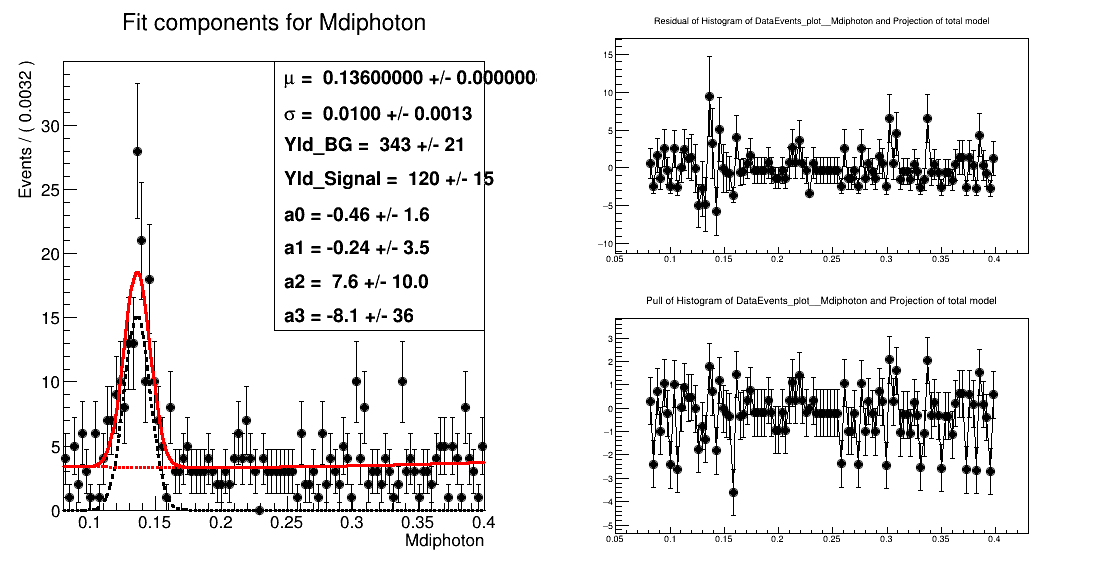

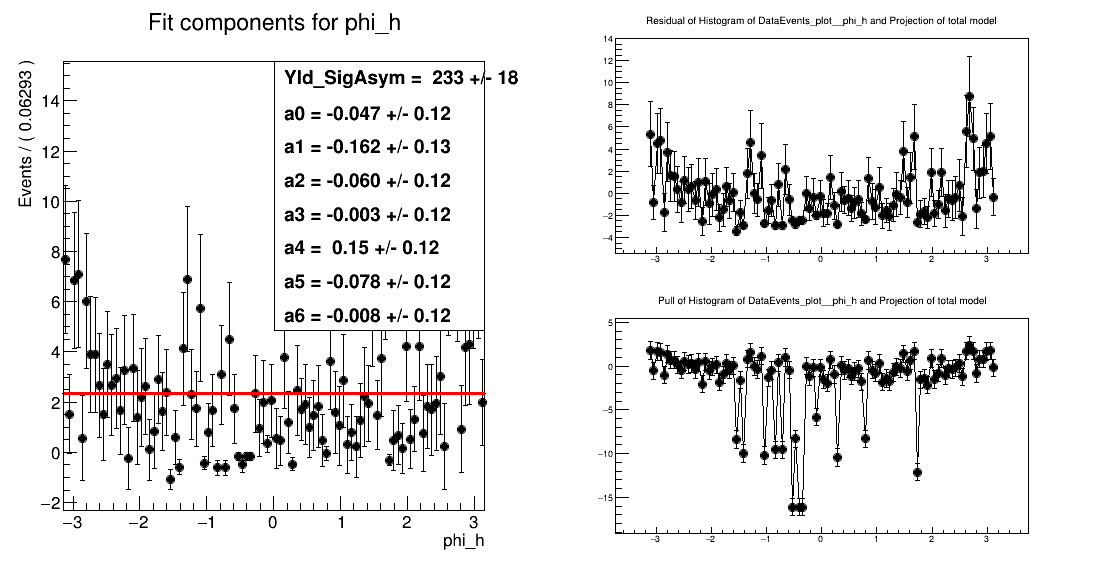

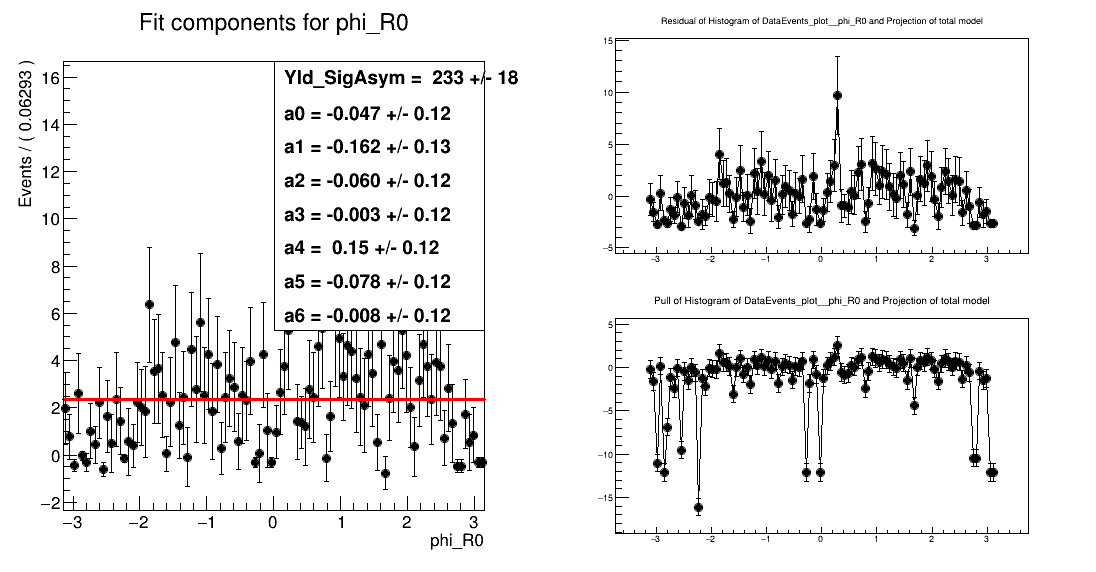

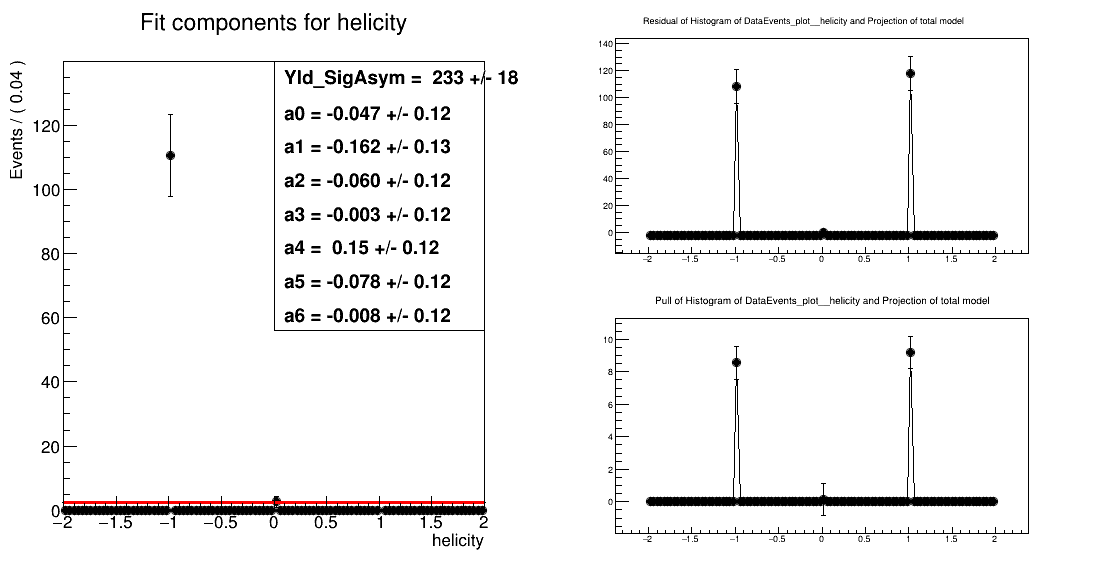

In [10]:
f=Fittify(datadir+"merged_run_binned.root",1)

In [ ]:
file="/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/MC/testall/merged_run_binned.root"
s=Systematicify(file,verbosity=0)

In [ ]:
s.dihadronContamination()

In [ ]:
s.dihadronParents()

In [ ]:
s.dihadronPIDs()

In [ ]:
s.confusionMatrix()

In [4]:
tfile = ROOT.TFile(datadir+"/merged_run_binned.root","READ")
for f in tfile.GetListOfKeys():
    #print(f.GetName())
    #os.system("python3 executeFitting.py {}merged_run_binned.root {}".format(datadir,f.GetName()))
    os.system("python3 executeFitting.py")
    break
#os.system("")


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



cling::DynamicLibraryManager::loadLibrary(): libCore.so.6.24: cannot open shared object file: No such file or directory
cling::DynamicLibraryManager::loadLibrary(): libcppyy3_4.so.6.24: cannot open shared object file: No such file or directory
Traceback (most recent call last):
  File "executeFitting.py", line 17, in <module>
    ROOT.sPlot()
  File "/opt/root/lib/ROOT/_facade.py", line 163, in _fallback_getattr
    raise AttributeError("Failed to get attribute {} from ROOT".format(name))
AttributeError: Failed to get attribute sPlot from ROOT


In [12]:
import os
import pandas as pd
import ROOT
os.system("python3 executeFitting.py")

256


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



cling::DynamicLibraryManager::loadLibrary(): libCore.so.6.24: cannot open shared object file: No such file or directory
cling::DynamicLibraryManager::loadLibrary(): libcppyy3_4.so.6.24: cannot open shared object file: No such file or directory
Traceback (most recent call last):
  File "executeFitting.py", line 17, in <module>
    ROOT.sPlot()
  File "/opt/root/lib/ROOT/_facade.py", line 163, in _fallback_getattr
    raise AttributeError("Failed to get attribute {} from ROOT".format(name))
AttributeError: Failed to get attribute sPlot from ROOT


In [10]:
import os
import sys
import subprocess
subprocess.run(["python3","executeFitting.py","/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/nSidis/testsmall/merged_run_binned.root","bin1d_x_0.1_0.13"])

CompletedProcess(args=['python3', 'executeFitting.py', '/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/nSidis/testsmall/merged_run_binned.root', 'bin1d_x_0.1_0.13'], returncode=1)


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



cling::DynamicLibraryManager::loadLibrary(): libCore.so.6.24: cannot open shared object file: No such file or directory
Info in <TUnixSystem::ACLiC>: creating shared library /work/clas12/users/gmat/CLAS12Analysis/brufit/macros/PDFExpand_C.so
IncrementalExecutor::executeFunction: symbol '_ZN2HS3FIT5Setup13LoadParameterERK7TString' unresolved while linking function '_GLOBAL__sub_I_cling_module_232'!
You are probably missing the definition of HS::FIT::Setup::LoadParameter(TString const&)
Maybe you need to load the corresponding shared library?
IncrementalExecutor::executeFunction: symbol '_ZN2HS3FIT5Setup12LoadConstantERK7TString' unresolved while linking function '_GLOBAL__sub_I_cling_module_232'!
You are probably missing the definition of HS::FIT::Setup::LoadConstant(TString const&)
Maybe you need to load the corresponding shared library?
IncrementalExecutor::executeFunction: symbol '_ZN2HS3FIT5Setup11LoadFormulaE7TString' unresolved while linking function '_GLOBAL__sub_I_cling_module_2

In [33]:
subprocess.run(["./genFits.sh","rga","nSidis","testsmall","bin1d_x_0.1_0.13"])

CompletedProcess(args=['./genFits.sh', 'rga', 'nSidis', 'testsmall', 'bin1d_x_0.1_0.13'], returncode=0)

In [16]:
os.system("bash","ls")

TypeError: system() takes at most 1 argument (2 given)